In [2]:
import argparse
import random
import numpy as np
from habitat_baselines.config.default import get_config
import habitat
import os
from habitat import Config, logger
from habitat import Config, Dataset
import matplotlib.pyplot as plt
import transformations as tf

In [3]:
import contextlib
import time
from collections import OrderedDict, defaultdict, deque
from typing import Any, Dict, List, Optional
from habitat_baselines.rl.ddppo.algo.ddp_utils import (
    EXIT,
    REQUEUE,
    add_signal_handlers,
    init_distrib_slurm,
    load_interrupted_state,
    requeue_job,
    save_interrupted_state,
)
from habitat_baselines.common.baseline_registry import baseline_registry
#from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.common.environments import get_env_class
from habitat_baselines.common.rollout_storage import RolloutStorage
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.common.utils import batch_obs, linear_decay
import numpy as np
import torch
import torch.distributed as distrib
import torch.nn as nn
from gym import spaces
from gym.spaces.dict_space import Dict as SpaceDict
from torch.optim.lr_scheduler import LambdaLR
from habitat_baselines.rl.ddppo.policy.resnet_policy import PointNavResNetPolicy
from habitat_baselines.rl.ddppo.algo.ddppo import DDPPO
from habitat_baselines.common.base_trainer import BaseRLTrainer
from habitat_baselines.common.baseline_registry import baseline_registry

In [4]:
from ppotrainer import PPOTrainer
from ddpotrainer import DDPPOTrainer
from constructenv import construct_envs
from env import MyRLEnvNew
from habitat import make_dataset
from constructenv import make_env_fn
from vectorenv import VectorEnv
from utils import FrameSkip, FrameStack, draw_top_down_map

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

# Config init

In [6]:
import fileinput
filename = "/habitat-api/habitat_baselines/config/pointnav/ddppo_pointnav.yaml"
with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace('\"configs/tasks/pointnav_gibson.yaml\"', '\"/habitat-api/configs/tasks/pointnav_gibson.yaml\"'), end='')
with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:        
    for line in file:    
        print(line.replace('GLOO', 'NCCL'), end='')

In [7]:
W = 256#640
H = 256#360
config_paths="/data/challenge_pointnav2020.local.rgbd.yaml"
config = habitat.get_config(config_paths=config_paths)
config.defrost()
config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.DATASET.DATA_PATH = '/data/v1/{split}/{split}.json.gz'
config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS = ["HEADING_SENSOR", "COMPASS_SENSOR", "GPS_SENSOR", "POINTGOAL_SENSOR", "POINTGOAL_WITH_GPS_COMPASS_SENSOR"]
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.POINTGOAL_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.GPS_SENSOR.DIMENSIONALITY = 3
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.AGENT_POSITION_SENSOR = habitat.Config()
config.TASK.AGENT_POSITION_SENSOR.TYPE = "position_sensor"
config.TASK.AGENT_POSITION_SENSOR.ANSWER_TO_LIFE = 42
config.TASK.SENSORS.append("AGENT_POSITION_SENSOR")
config.SIMULATOR.TURN_ANGLE = 0.5
config.SIMULATOR.TILT_ANGLE = 0.5
config.SIMULATOR.FORWARD_STEP_SIZE = 0.0125
config.ENVIRONMENT.MAX_EPISODE_STEPS = 500*20
config.TASK.TOP_DOWN_MAP.MAX_EPISODE_STEPS = 500*20
config.DATASET.SCENES_DIR = '/data'
config.DATASET.SPLIT = 'train'
config.SIMULATOR.SCENE = '/data/gibson/Aldrich.glb'
#config.SIMULATOR_GPU_ID = 0
config.freeze()

In [8]:
config2 = get_config('/habitat-api/habitat_baselines/config/pointnav/ddppo_pointnav.yaml', [])
ii = 0
for i in config2.TASK_CONFIG.keys():
    config2.TASK_CONFIG[i] = config[i]
    ii+=1
config = config2    

In [9]:
config.defrost()
config.TASK_CONFIG.DATASET.DATA_PATH = '/data/v1/{split}/{split}.json.gz'
config.TASK_CONFIG.DATASET.SCENES_DIR = '/data'
config.TASK_CONFIG.DATASET.SPLIT = 'train'
config.TASK_CONFIG.SIMULATOR.SCENE = '/data/gibson/Aldrich.glb'
config.TASK_CONFIG.TASK.GOAL_SENSOR_UUID = 'pos'#'pointgoal_with_gps_compass'
config.NUM_UPDATES = 50000
config.ENV_NAME = 'MyRLEnvNew'
config.NUM_PROCESSES = 4
config.RL.FRAMESKIP = 20
config.RL.FRAMESTACK = 1
config.freeze()

## Construct one env (example)

In [10]:
print(config.ENV_NAME)
env_class = get_env_class(config.ENV_NAME)
dataset = make_dataset(config.TASK_CONFIG.DATASET.TYPE, config=config.TASK_CONFIG.DATASET)
one_env = env_class(config=config, dataset=dataset)

2020-04-20 11:47:26,060 Initializing dataset PointNav-v1


MyRLEnvNew


2020-04-20 11:49:07,228 initializing sim Sim-v0
2020-04-20 11:49:11,572 Initializing task Nav-v0


In [11]:
obs = one_env.reset()

Env is done:  False
Current coordinates:  [-0.010852810071638443, -0.1271613578026929]
Goal coordinates:  [3.6716153970517493, 3.1951804621038757]
Distance to goal:  [-3.68246821 -3.32234182]


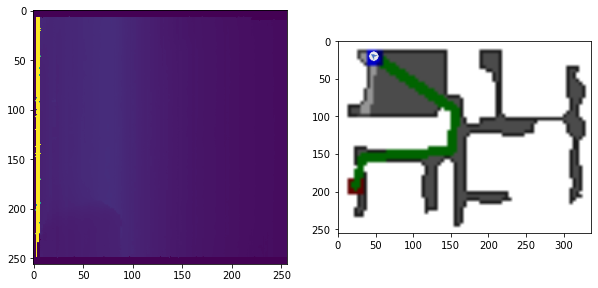

In [12]:
observations, rewards, dones, infos = one_env.step(action=3)
top_down_map = draw_top_down_map(infos, one_env.obs["heading"][0], one_env.obs['rgb'][0].shape[0])
plt.rcParams["figure.figsize"] = [10,10]
plt.subplot(1, 2, 1)
plt.imshow(observations['depth'][:,:,0])
plt.subplot(1, 2, 2)
plt.imshow(top_down_map)
print('Env is done: ',dones)
print('Current coordinates: ',[one_env.trux,one_env.truy])
print('Goal coordinates: ',[one_env.goalx, one_env.goaly])
print('Distance to goal: ',observations['pos'])

## Construct multiple envs with VectorEnv (example)

In [10]:
num_processes = config.NUM_PROCESSES
configs = [config.clone() for i in range(num_processes)]
env_class = get_env_class(config.ENV_NAME)
env_classes = [env_class for _ in range(num_processes)]

envs = VectorEnv(make_env_fn=make_env_fn,
                env_fn_args=tuple(tuple(zip(configs, env_classes, range(num_processes)))))

In [11]:
obs = envs.reset()

Env is done:  [False, True, False, False]
Current coordinates:  [[0.0, -0.0], [0, 0], [0.0, 0.0], [0.0, 0.0]]
Goal coordinates:  [[-3.5805551791662182, -2.679196743347948], [3.03660953066954, -3.774702505809769], [3.282126369898093, -2.1211995405329493], [6.049706151078575, -5.3510740687665965]]
Distance to goal:  [[3.5805551791662182, 2.679196743347948], [-3.03660953066954, 3.774702505809769], [-3.282126369898093, 2.1211995405329493], [-6.049706151078575, 5.3510740687665965]]


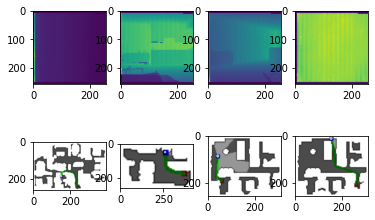

In [24]:
outputs = envs.step([2,0,2,2])

observations, rewards, dones, infos = [list(x) for x in zip(*outputs)]

OBSERVATION_SPACE_COMMAND = 'obs'
for write_fn in envs._connection_write_fns:
    write_fn((OBSERVATION_SPACE_COMMAND, None))
obs = [read_fn() for read_fn in envs._connection_read_fns]

OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns]

figure, axes = plt.subplots(nrows=2, ncols=config.NUM_PROCESSES)
for i in range(config.NUM_PROCESSES):
    top_down_map = draw_top_down_map(infos[i], obs[i]["heading"][0], obs[i]['rgb'][0].shape[0])
    axes[0, i].imshow(observations[i]['depth'][:,:,0])
    axes[1, i].imshow(top_down_map)
    
print('Env is done: ',dones)
print('Current coordinates: ',list(map(list, zip(*OBSERVATION_SPACE_COMMAND[:2]))))
print('Goal coordinates: ',list(map(list, zip(*OBSERVATION_SPACE_COMMAND[2:]))))
print('Distance to goal: ',[list(observations[i]['pos']) for i in range(config.NUM_PROCESSES)])

## How to communicate with VectorEnv manually (example)

In [ ]:
data = [0,0,0,0]
STEP_COMMAND = "step"

if isinstance(data[0], (int, np.integer, str)):
    data = [{"action": {"action": action}} for action in data]
envs._is_waiting = True
for write_fn, args in zip(envs._connection_write_fns, data):
    write_fn((STEP_COMMAND, args))

outputs = []
for read_fn in envs._connection_read_fns:
    outputs.append(read_fn())
observations, rewards, dones, infos = [list(x) for x in zip(*outputs)]    
envs._is_waiting = False
plt.imshow(observations[1]['depth'][:,:,0])

In [ ]:
OBSERVATION_SPACE_COMMAND = 'obs'
for write_fn in trainer.envs._connection_write_fns:
    write_fn((OBSERVATION_SPACE_COMMAND, None))
obs = [read_fn() for read_fn in trainer.envs._connection_read_fns]

In [ ]:
outputs = trainer.envs.step([3 for i in range(config.NUM_PROCESSES)])
observations, rewards, dones, infos = [list(x) for x in zip(*outputs)]

# Run training process

In [10]:
random.seed(config.TASK_CONFIG.SEED)
np.random.seed(config.TASK_CONFIG.SEED)

In [11]:
config.defrost()
config.RL.DDPPO.pretrained_weights = 'gibson-2plus-resnet50.pth'
config.RL.DDPPO.pretrained_encoder = False
config.RL.DDPPO.pretrained = False
config.freeze()

In [12]:
trainer_init = baseline_registry.get_trainer(config.TRAINER_NAME)

In [13]:
trainer = trainer_init(config)

2020-04-20 11:49:42,693 config: BASE_TASK_CONFIG_PATH: /habitat-api/configs/tasks/pointnav_gibson.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: 50
CMD_TRAILING_OPTS: []
ENV_NAME: MyRLEnvNew
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
LOG_FILE: train.log
LOG_INTERVAL: 10
NUM_PROCESSES: 4
NUM_UPDATES: 50000
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.txt
RL:
  DDPPO:
    backbone: resnet50
    distrib_backend: NCCL
    num_recurrent_layers: 2
    pretrained: Fals

In [14]:
trainer.train_init()

2020-04-20 11:49:45,366 Initializing dataset PointNav-v1


0


2020-04-20 11:50:24,001 agent number of trainable parameters: 12454917


In [16]:
pretrained_state = torch.load(config.RL.DDPPO.pretrained_weights, map_location="cpu")
trainer.actor_critic.net.visual_encoder.backbone.load_state_dict({k[len("actor_critic.net.visual_encoder.backbone.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic.net.visual_encoder.backbone" in k})
for param in trainer.actor_critic.net.visual_encoder.backbone.parameters():
    param.requires_grad = False
trainer.actor_critic.net.prev_action_embedding.load_state_dict({k[len("actor_critic.net.prev_action_embedding.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic.net.prev_action_embedding" in k})
for param in trainer.actor_critic.net.prev_action_embedding.parameters():
    param.requires_grad = False
trainer.actor_critic.net.tgt_embeding.load_state_dict({k[len("actor_critic.net.tgt_embeding.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic.net.tgt_embeding" in k})
for param in trainer.actor_critic.net.tgt_embeding.parameters():
    param.requires_grad = False
trainer.actor_critic.net.visual_encoder.compression.load_state_dict({k[len("actor_critic.net.visual_encoder.compression.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic.net.visual_encoder.compression" in k})
for param in trainer.actor_critic.net.visual_encoder.compression.parameters():
    param.requires_grad = False
trainer.actor_critic.net.visual_fc.load_state_dict({k[len("actor_critic.net.visual_fc.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic.net.visual_fc" in k})
for param in trainer.actor_critic.net.visual_fc.parameters():
    param.requires_grad = False
trainer.actor_critic.net.state_encoder.load_state_dict({k[len("actor_critic.net.state_encoder.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic.net.state_encoder" in k})
for param in trainer.actor_critic.net.state_encoder.parameters():
    param.requires_grad = False
trainer.actor_critic.critic.load_state_dict({k[len("actor_critic.critic.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic.critic" in k})
#for param in trainer.actor_critic.critic.parameters():
#    param.requires_grad = False
trainer.actor_critic.action_distribution.load_state_dict({k[len("actor_critic.action_distribution.") :]: v for k, v in pretrained_state["state_dict"].items() if "actor_critic.action_distribution" in k})
#for param in trainer.actor_critic.action_distribution.parameters():
#    param.requires_grad = False

<All keys matched successfully>

In [ ]:
trainer.train()

RESET
{'distance_to_goal': 6.347223281860352, 'spl': 0.0, 'success': 0.0, 'top_down_map.agent_angle': -1.5574531555175781}
{'distance_to_goal': 0.0, 'spl': 0.0, 'success': 0.0, 'top_down_map.agent_angle': 0.0}
{'distance_to_goal': 4.617747783660889, 'spl': 0.0, 'success': 0.0, 'top_down_map.agent_angle': -0.6120705604553223}
{'distance_to_goal': 3.82579345703125, 'spl': 0.0, 'success': 0.0, 'top_down_map.agent_angle': -1.2838016510009767}
{'distance_to_goal': 5.246660444471571, 'spl': 0.0, 'success': 0.0, 'top_down_map.agent_angle': -1.9643819597032335}
{'distance_to_goal': 5.053762582632212, 'spl': 0.0, 'success': 0.0, 'top_down_map.agent_angle': -1.7681915576641376}
{'distance_to_goal': 4.832377115885417, 'spl': 0.0, 'success': 0.0, 'top_down_map.agent_angle': -1.3591558668348525}
{'distance_to_goal': 5.1124626159667965, 'spl': 0.0, 'success': 0.0, 'top_down_map.agent_angle': -1.359938621520996}
{'distance_to_goal': 4.803353945414226, 'spl': 0.002036044684549173, 'success': 0.0416666

2020-04-20 11:59:07,721 update: 10	fps: 11.347	
2020-04-20 11:59:07,724 update: 10	env-time: 454.384s	pth-time: 41.441s	frames: 5632.0
2020-04-20 11:59:07,725 Average window size: 11  distance_to_goal: 5.258  reward: -0.738  spl: 0.002  success: 0.032  top_down_map.agent_angle: -1.325


{'distance_to_goal': 5.2581614832724295, 'spl': 0.001576292659005811, 'success': 0.03225806451612903, 'top_down_map.agent_angle': -1.3245382001323085}
{'distance_to_goal': 5.362117658342634, 'spl': 0.001396144926548004, 'success': 0.02857142857142857, 'top_down_map.agent_angle': -1.4878923688616073}
{'distance_to_goal': 5.362117658342634, 'spl': 0.001396144926548004, 'success': 0.02857142857142857, 'top_down_map.agent_angle': -1.4878923688616073}
{'distance_to_goal': 5.524390616068026, 'spl': 0.0011918310348580524, 'success': 0.024390243902439025, 'top_down_map.agent_angle': -1.673659161823552}
{'distance_to_goal': 5.524390616068026, 'spl': 0.0011918310348580524, 'success': 0.024390243902439025, 'top_down_map.agent_angle': -1.673659161823552}
{'distance_to_goal': 5.490209621853299, 'spl': 0.002034140792157915, 'success': 0.044444444444444446, 'top_down_map.agent_angle': -1.7540483262803819}
{'distance_to_goal': 5.648767588089924, 'spl': 0.0018680884825940036, 'success': 0.0408163265306

2020-04-20 12:06:30,205 update: 20	fps: 11.452	
2020-04-20 12:06:30,207 update: 20	env-time: 859.044s	pth-time: 78.845s	frames: 10752.0
2020-04-20 12:06:30,208 Average window size: 21  distance_to_goal: 5.658  reward: -0.661  spl: 0.002  success: 0.036  top_down_map.agent_angle: -1.635


{'distance_to_goal': 5.657634190150669, 'spl': 0.0016345774222697531, 'success': 0.03571428571428571, 'top_down_map.agent_angle': -1.6351473672049386}
{'distance_to_goal': 5.622313452548668, 'spl': 0.0015005956663460029, 'success': 0.03278688524590164, 'top_down_map.agent_angle': -1.5665821012903431}
{'distance_to_goal': 5.622313452548668, 'spl': 0.0015005956663460029, 'success': 0.03278688524590164, 'top_down_map.agent_angle': -1.5665821012903431}
{'distance_to_goal': 5.777712735262784, 'spl': 0.0013869141764713056, 'success': 0.030303030303030304, 'top_down_map.agent_angle': -1.6176565921667851}
{'distance_to_goal': 5.6595750696518845, 'spl': 0.00181371729601832, 'success': 0.04411764705882353, 'top_down_map.agent_angle': -1.6084085352280562}
{'distance_to_goal': 5.667204091246699, 'spl': 0.0017370813539330388, 'success': 0.04225352112676056, 'top_down_map.agent_angle': -1.6486990485392825}
{'distance_to_goal': 5.67849365234375, 'spl': 0.0020871941248575845, 'success': 0.053333333333

2020-04-20 12:14:10,314 update: 30	fps: 11.346	
2020-04-20 12:14:10,317 update: 30	env-time: 1281.573s	pth-time: 116.007s	frames: 15872.0
2020-04-20 12:14:10,318 Average window size: 31  distance_to_goal: 5.836  reward: -0.856  spl: 0.002  success: 0.049  top_down_map.agent_angle: -1.727


{'distance_to_goal': 5.836176058141197, 'spl': 0.0019090190166380348, 'success': 0.04878048780487805, 'top_down_map.agent_angle': -1.7274882618973895}
{'distance_to_goal': 5.980091566450141, 'spl': 0.0017588714535316725, 'success': 0.0449438202247191, 'top_down_map.agent_angle': -1.7048074100794417}
{'distance_to_goal': 5.980091566450141, 'spl': 0.0017588714535316725, 'success': 0.0449438202247191, 'top_down_map.agent_angle': -1.7048074100794417}
{'distance_to_goal': 5.930213080512153, 'spl': 0.0017393284373813205, 'success': 0.044444444444444446, 'top_down_map.agent_angle': -1.6896280924479166}
{'distance_to_goal': 6.042275470236073, 'spl': 0.0017015169496121614, 'success': 0.043478260869565216, 'top_down_map.agent_angle': -1.7327197530995244}
{'distance_to_goal': 6.055672327677409, 'spl': 0.001630620410044988, 'success': 0.041666666666666664, 'top_down_map.agent_angle': -1.7401905059814453}
{'distance_to_goal': 5.89903455677599, 'spl': 0.0015498966273694936, 'success': 0.039603960396

2020-04-20 12:21:54,068 update: 40	fps: 11.270	
2020-04-20 12:21:54,070 update: 40	env-time: 1707.262s	pth-time: 153.639s	frames: 20992.0
2020-04-20 12:21:54,071 Average window size: 41  distance_to_goal: 5.981  reward: -0.889  spl: 0.001  success: 0.034  top_down_map.agent_angle: -1.706


{'distance_to_goal': 5.980552936422414, 'spl': 0.0013494789600372314, 'success': 0.034482758620689655, 'top_down_map.agent_angle': -1.7058054167648842}
{'distance_to_goal': 6.062031208967962, 'spl': 0.0013154584820530995, 'success': 0.03361344537815126, 'top_down_map.agent_angle': -1.7204839882730436}
{'distance_to_goal': 6.03416748046875, 'spl': 0.0013044963280359903, 'success': 0.03333333333333333, 'top_down_map.agent_angle': -1.694996134440104}
{'distance_to_goal': 6.03416748046875, 'spl': 0.0013044963280359903, 'success': 0.03333333333333333, 'top_down_map.agent_angle': -1.694996134440104}
{'distance_to_goal': 6.062120281282018, 'spl': 0.0012831111423304824, 'success': 0.03278688524590164, 'top_down_map.agent_angle': -1.662151023989818}
